# Processing of a DARTMS dataset 

Dataset: Different application volumes of serum (2 and 10 ul) (generated by Nicola Zabalegui, https://cibion.conicet.gov.ar/)

Software: DARTMS module of tidyms

This Juypter notebook demonstrates the use of TidyMS's new DARTMS processing functionality. As a DARTMS experiment is fundamentally different from LC-HRMS experiments (i.e., no chromatographic separation), all new functionality is located in the tidyms.dartms submodule. 

## Setup

In [1]:
## Import tidyMS
## Since it is not yet packed, load it from the development directory
import sys

sys.path.append("D:/Projects/DARTMS/tidyms/src/")
import tidyms as ms

## Import some other packages to be used
import warnings
import plotnine as p9
import numpy as np
import natsort
import os
import shutil
import functools
import logging


## Common parameters
warnings.simplefilter(action="ignore", category=FutureWarning)
p9.options.figure_size = (14, 12)
logging.basicConfig(level=logging.INFO)


Loading BokehJS ...

## Specify the data to be loaded

Data for the TidyMS DARTMS module must be in the mzML file format. Furthermore, the MS data must be in centroid mode. 

The conversion and centroiding can be achieved with msConvert. For this, start the msConvert gui and set the parameters accordingly. 
--filter "peakPicking cwt snr=1 peakSpace=0.033 msLevel=1- centroid=true" --mzML -v -z --noindex
For the here used demonstration dataset, the following parameters (apart from the default values) can be used:
* remove all filters that might be predevined
* add a peak-picking filter with the options: 
  * Algorithm: CWT 
  * MS Levels: 1 - 
  * Min. SNR: 1
  * Min. peak spacing: 0.033

In [2]:
## specify the parth where the mzML files are located
path = "D:/Projects/DARTMS/Serum_InjectionVolumne/mzML/"

## all mzML files are automatically fetched from the path
filenames = natsort.natsorted([os.path.join(path, file) for file in os.listdir(path) if file.endswith(".mzML") and not "_rtShifted.mzML" in file])

## specify some aquisition parameters
ms_mode = "centroid"
instrument = "qtof"

## specify the file to be used for storing the automatically detected spots. After the first execution this file can be modified by the user.
spotFile = "./defined_spots.tsv"

## specify a dill file to be used to store intermediate results
temp_file = "./temp_assay.dill"


## Rewrite mzML files

The first data processing step is to import the mzML files and re-write their quasi-retention times. Doing this allows to visualize the results in TOPPView without having overlapping chronograms. 

This step is a bit tricky to execute: 
1. Execute the code chunk with 'executeStep = 1'. This will generate a spots file in the locations specified in the variable spotFile. Here the parameter intensity_threshold_spot_extraction is important to separate the spots in the chronograms into spots automatically. 
2. Open the spots file with Excel or any other spreadsheet tool and review the extracted spots. Any information in there can be changed. Include or exclude certain spots by setting the column 'include' to True or False, modify the spots' group and batch information by changing the columns 'group' and 'batch' and modify the spots' names by changing the column name. Spots (rows) can also be deleted and their chronogram times can be changed. Save the changed data matrix. 
3. Change the variable in line 1 to 'executeStep = 2' and execute the code chunk once more. This will re-import the mzML files and generate derived mzML files from the previously found and used spots. Only the chronogram times that will be used for the spots is included in there. Verify that the time change worked by loading all files into ToppView. Additionally, a new spots file will be generated which contains the shifted chronogram times. 
4. Change the variable in line 1 to 'executeStep = 3'. This will deactivate this step and only modify the parameter variables to use this new mzML files and the derived spots file. 
5. Restart the kernel. Now the data has been rewritten and this will be used

Attention: Whenever the spots file changes, the rewritten data is invalid. Thus, whenever this happens please delete the mzML files with the postfix "_rtShifted" and also delete the spots file with the postfix "_rtShifted". 

Attention: These steps might be complicated. If you do not feel save with them, delete this entire code chunk (or set executeStep to None or any value other than 1, 2, or 3) and continue using not re-written mzML files. 


In [3]:
executeStep = 3

if executeStep == 1:
    logging.info("Shifting RTs of chronograms for improved visualization")
    assay = ms.dartms.DartMSAssay.create_assay_from_chronogramFiles(
        "NA",
        filenames,
        ms_mode=ms_mode,
        instrument=instrument,
        spot_file=spotFile,
        centroid_profileMode=True,
        intensity_threshold_spot_extraction=2.5e4,
        fileNameChangeFunction=lambda x: x.replace("20220316-HE-350V-400C-POS-", "").replace("20220316-HE-350V-500C-POS-", ""),
        rewriteRTinFiles=False,
    )
    logging.info("")

elif executeStep == 2:
    if os.path.exists(spotFile):
        shutil.copy2(spotFile, spotFile.replace(".tsv", "_rtShifted.tsv"))
        spotFile = spotFile.replace(".tsv", "_rtShifted.tsv")

    ## Import chronograms and separate them into spots.
    ## Apply a retention time shift relative to the
    logging.info("Shifting RTs of chronograms for improved visualization")
    assay = ms.dartms.DartMSAssay.create_assay_from_chronogramFiles(
        "NA",
        filenames,
        ms_mode=ms_mode,
        instrument=instrument,
        spot_file=spotFile,
        centroid_profileMode=True,
        fileNameChangeFunction=lambda x: x.replace("20220316-HE-350V-400C-POS-", "").replace("20220316-HE-350V-500C-POS-", ""),
        rewriteRTinFiles=True,
    )
    logging.info("")
    filenames = natsort.natsorted([os.path.join(path, file) for file in os.listdir(path) if file.endswith("_rtShifted.mzML")])
    temp_file = temp_file.replace(".dill", "_rtShifted.dill")

    logging.info("")
    logging.warning("ATTENTION: input changed to rewritten mzML files with changed RTs")

elif executeStep == 3:
    filenames = natsort.natsorted([os.path.join(path, file) for file in os.listdir(path) if file.endswith("_rtShifted.mzML")])
    temp_file = temp_file.replace(".dill", "_rtShifted.dill")
    spotFile = spotFile.replace(".tsv", "_rtShifted.tsv")

else:
    pass


## Import mzML files

The next code chunk imports the mzML files. If these have already been processed previously and saved to a dill file, these results will be loaded. 

The main processing steps are

1. Import the raw data (either original or chronogram time shifted ones) using the previously defined spots file. 
2. Correct mz shifts throughout the measurement sequence and batches using a series of pre-defined reference MZ values. 
3. Plot the exctracted spots. The black dots indicate the start and end and shall help find incorrectly defined spots. 
4. Calculate consensus spectra from the spots (i.e., a single, average or median spectrum representing the spot)
5. (optional) Normalize consensus spectra to internal standard 
6. Bracket the features across the different samples of the dataset
7. Save intermediate results to a file to easily laod them. 

INFO:root:Importing and separating chronograms
INFO:root: Creating empty assay
INFO:root:    .. processing input file 'D:/Projects/DARTMS/Serum_InjectionVolumne/mzML/20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING_rtShifted.mzML'
INFO:root:       .. adding subset    0 with name 'VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING_rtShifted::Airblank_1)' (group 'Airblank', class 'unknown'), width   40.6 sec, RTs   15.0 -   55.6
INFO:root:       .. adding subset    1 with name 'VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING_rtShifted::Airblank_2)' (group 'Airblank', class 'unknown'), width   42.6 sec, RTs   64.7 -  107.3
INFO:root:       .. adding subset    2 with name 'VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING_rtShifted::Airblank_3)' (group 'Airblank', class 'unknown'), width   41.6 sec, RTs  116.5 -  158.1
INFO:root:       .. adding subset    3 with name 'VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLE

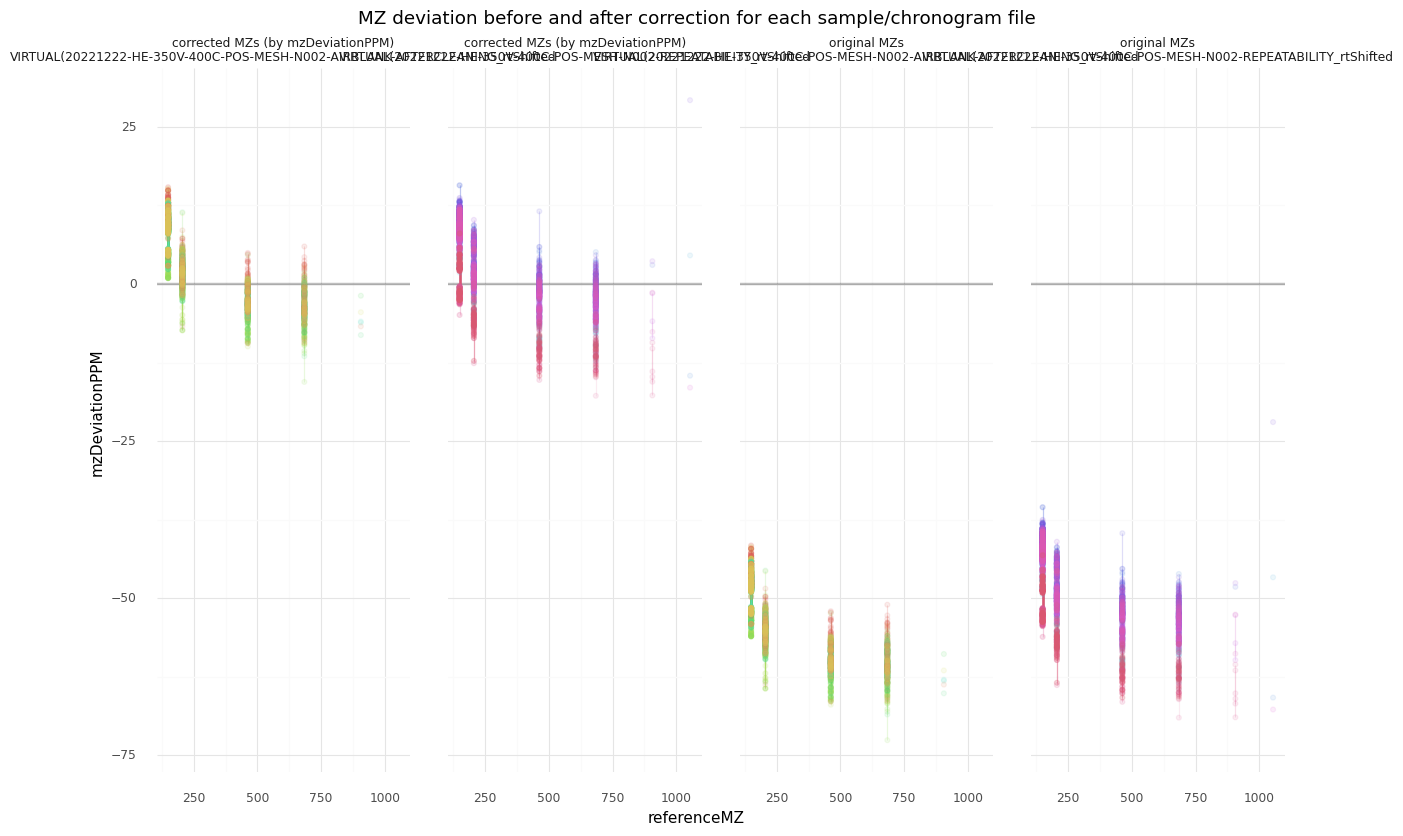

INFO:root:


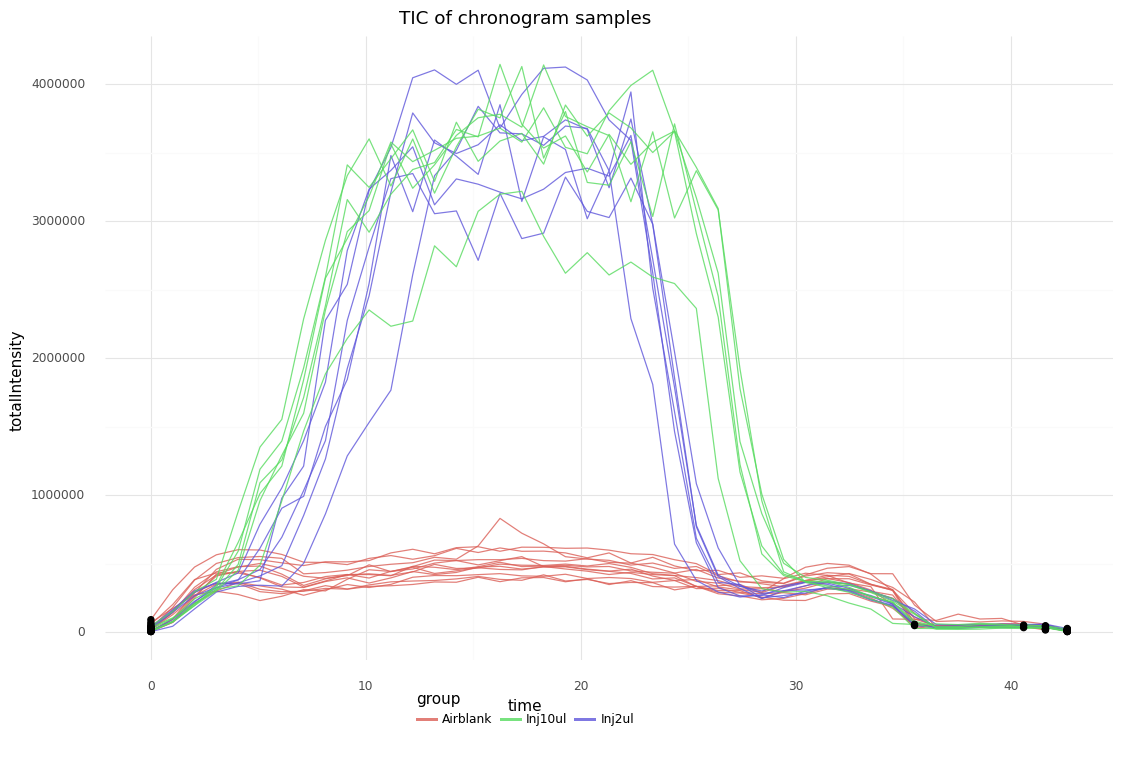

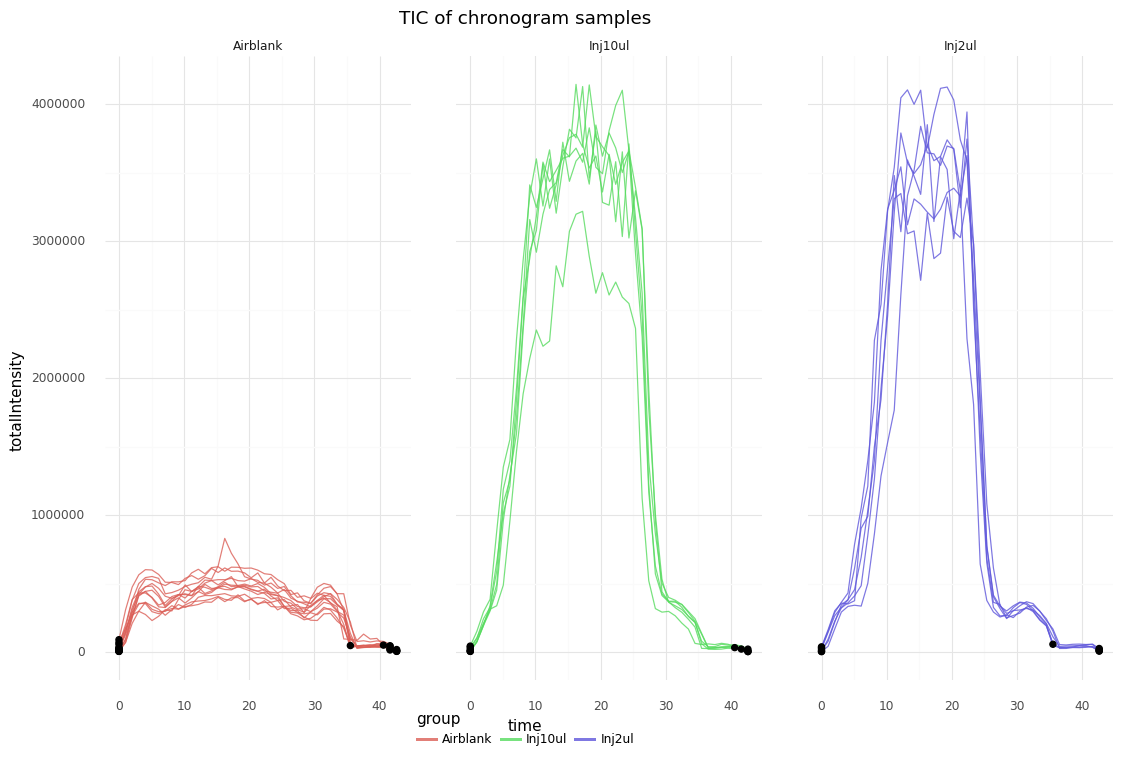

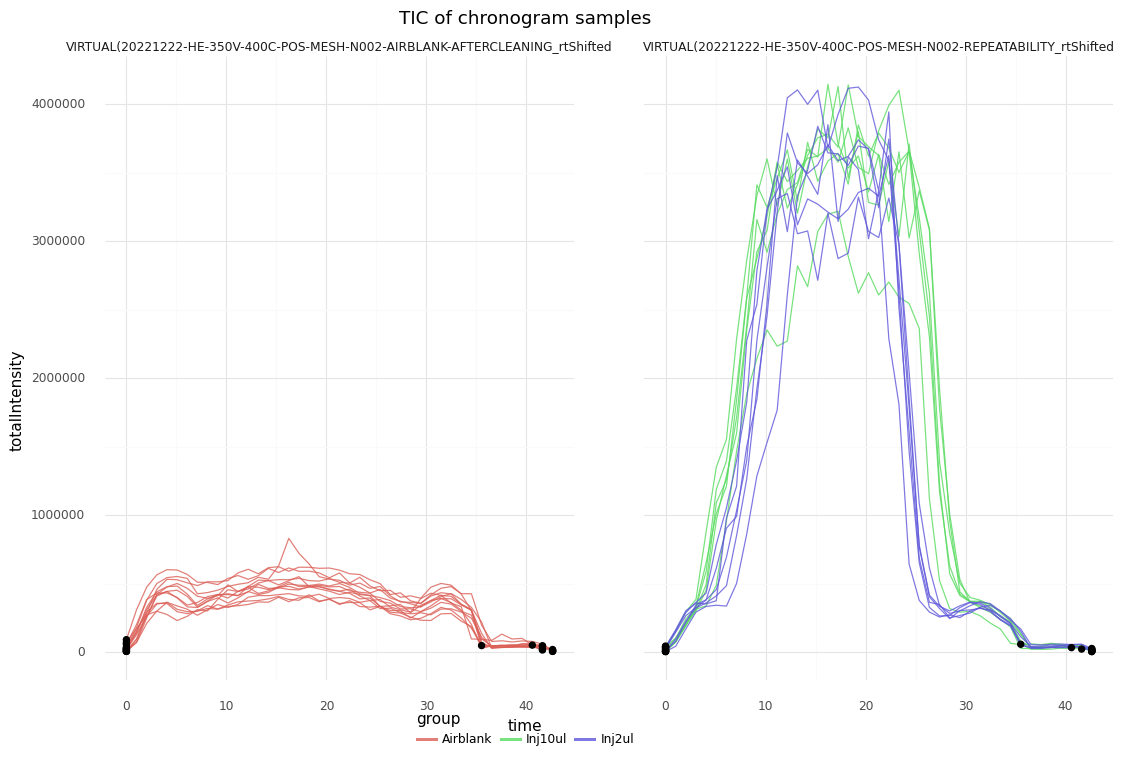

INFO:root:Collapsing multiple spectra of samples to consensus spectra for each sample


INFO:root:    .. Sample    1 /   24 (VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING_rtShifted::Airblank_1)): spectra  41, signals  18970, cluster after crude   1011, fine    511, quality control    343, final number of features    342
INFO:root:    .. Sample    2 /   24 (VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING_rtShifted::Airblank_2)): spectra  43, signals  22317, cluster after crude   1105, fine    600, quality control    376, final number of features    375
INFO:root:    .. Sample    3 /   24 (VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING_rtShifted::Airblank_3)): spectra  42, signals  22298, cluster after crude   1086, fine    621, quality control    337, final number of features    336
INFO:root:    .. Sample    4 /   24 (VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING_rtShifted::Airblank_4)): spectra  43, signals  24918, cluster after crude   1836, fine    893, quality control    378, final number

In [4]:
p9.options.figure_size = (12, 8)

if os.path.exists(temp_file) and os.path.isfile(temp_file):
    ## Load data from last session
    logging.info("Loading previous results from cache files")
    logging.info("")

    dartMSAssay = ms.dartms.DartMSAssay.read_from_dill_file(temp_file)

else:
    ## Step 1
    ## Process samples if the last results cannot be loaded
    ## Import chronograms and separate them into spots.
    logging.info("Importing and separating chronograms")
    dartMSAssay = ms.dartms.DartMSAssay.create_assay_from_chronogramFiles(
        "InjectionVolumeTest",
        filenames,
        ms_mode=ms_mode,
        instrument=instrument,
        spot_file=spotFile,
        centroid_profileMode=True,
        fileNameChangeFunction=lambda x: x.replace("20221230-HE-350V-400C-D25MM-POS-", "").replace("20220316-HE-350V-500C-POS-", ""),
        intensity_threshold_spot_extraction=5e4,
        import_filters=[functools.partial(ms.dartms.import_filter_remove_signals_below_intensity, minimum_signal_intensity=1e2)],
    )
    logging.info("")

    ## Step 2
    ## Account for and correct mz values of individual spots by reference mz values
    ## This step can be applied sequentially several times
    ## 
    ## Method one: using reference features
    logging.info("Correcting for mz shifts between samples (not chronograms) with reference mz values")
    referenceMZs = sorted([149.03353, 205.10074, 462.18112, 684.25456, 906.32974, 1054.38123])
    dartMSAssay.correct_MZ_shift_across_samples(
        referenceMZs,
        max_mz_deviation_absolute=0.1,
        max_deviationPPM_to_use_for_correction=200,
        correctby="mzDeviationPPM",
        selection_criteria="mostabundant",
        correct_on_level="file",
        plot=True,
    )
    logging.info("")
    
    if False:
        ## Method 2: using observed and true-value features
        samplesA = [] ## list of sample names
        samplesB = [] ## list of sample names
        referenceMZs = [
            {  ## Correct samples in samplesA by a much higher mz deviation
               "observedMZ": 283.34,        ## the observed mz vlaues (with the deviation)
               "referenceMZ": 283.26401,    ## the reference/true values of the respective mz values
               "forSamples": sampleSetA,    ## list of sample names to apply this correction for
            },
            {  ## Correct samples in samplesB by only a minor mz deviation
               "observedMZ": 283.26401,
               "referenceMZ": 283.26401,
               "forSamples": sampleSetB,
            },
        ]
        dartMSAssay.correct_MZ_shift_across_samples(
            referenceMZs,
            max_mz_deviation_absolute=0.03,
            max_deviationPPM_to_use_for_correction=800,
            correctby="mzDeviationPPM",
            selection_criteria="mostabundant",
            correct_on_level="sample",
            plot=False,
        )

    ## Step 3
    ## Plot overview of chronogram samples
    dartMSAssay.plot_sample_TICs(separate=False)
    dartMSAssay.plot_sample_TICs(separate=True)
    dartMSAssay.plot_sample_TICs(separate=True, separate_by="file")

    ## Step 4
    ## Calculate consensus spectra for each spot file to reduce following processing time
    logging.info("Collapsing multiple spectra of samples to consensus spectra for each sample")
    dartMSAssay.calculate_consensus_spectra_for_samples(
        min_difference_ppm=100,
        min_signals_per_cluster=5,
        minimum_intensity_for_signals=2.5e2,
        cluster_quality_check_functions=[
            functools.partial(ms.dartms.cluster_quality_check_function__ppmDeviationCheck, max_weighted_ppm_deviation=15),
            functools.partial(ms.dartms.cluster_quality_check_function__peak_form, min_correlation_for_cutoff=0.25),
        ],
        aggregation_function="average",
        featureMLlocation="./",
    )
    logging.info("")

    ## Step 5
    ## Normalize to internal standard
    if False:
        logging.info("Normalize to internal standard")
        std = (316.29, 316.325)
        dartMSAssay.normalize_to_internal_standard(std, multiplication_factor=1e6, plot=True)
    logging.info("")

    ## Step 6
    ## Bracket/group mz features across samples of the experiment
    logging.info("Bracketing features across samples")
    dartMSAssay.bracket_consensus_spectrum_samples(max_ppm_deviation=25, show_diagnostic_plots=False)
    dartMSAssay.write_bracketing_results_to_featureML(featureMLlocation="./bracketedResults.featureML", featureMLStartRT=0, featureMLEndRT=1400)
    logging.info("   .. bracketed to %d features" % (len(dartMSAssay.features)))
    logging.info("")

    ## Step 7
    # Save assay to file for quick prototyping
    dartMSAssay.save_self_to_dill_file(temp_file)
    logging.info("Save assay and bracketing results to file (%s)" % (temp_file))


## Mass deviations

Constant mass shifts can be visualized in the following code chunk. This helps to adapt certain parameters during consensus spectra calculation and bracketing of features. 

The generated plots show the raw and consensus, corrected mz values found for signals and features in the samples.  

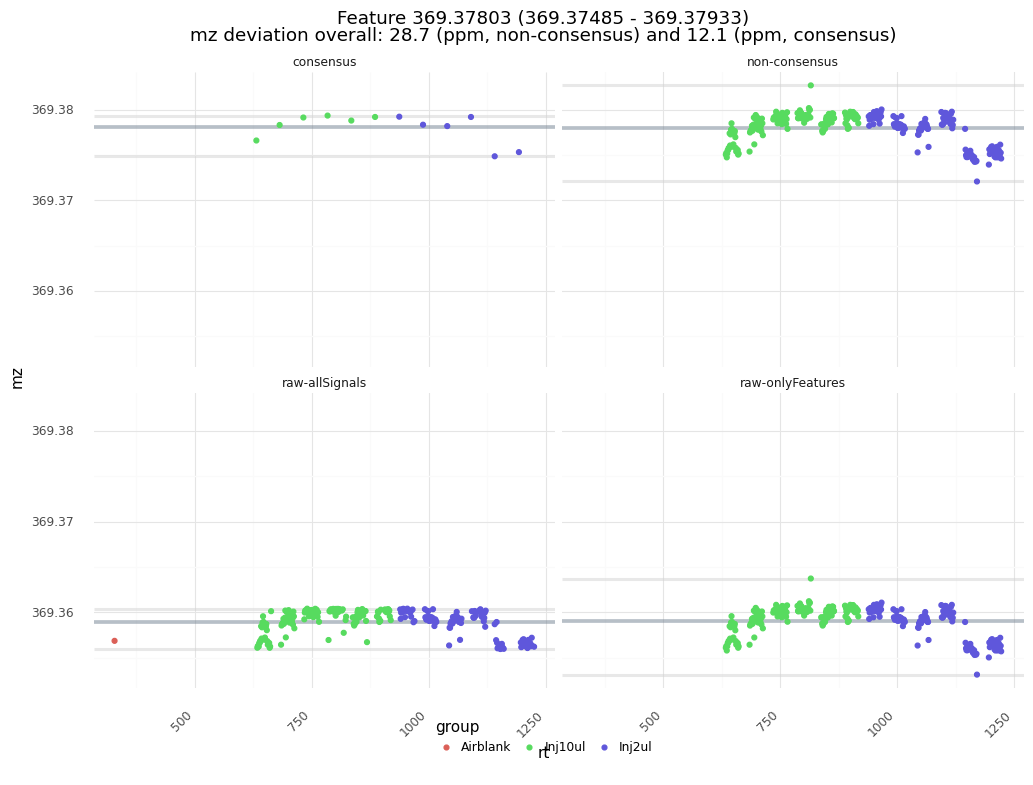

In [5]:
featureMZs = [369.37817]

for featureMZ in featureMZs:
    dartMSAssay.plot_feature_mz_deviations(
        np.argmin(np.abs(np.array([avmz for _, avmz, _, _ in dartMSAssay.features]) - featureMZ)),
        types=["consensus", "non-consensus", "raw-onlyFeatures", "raw-allSignals"],
    )


## Data matrix

The next step is to build a data matrix from the found features and samples. Depening on the chosen option (parameter on) this is done on the raw data and thus includes an automated re-integration step of low-abundant signals (on = 'originalData') or only the detected features (on = 'processedData')

Furthermore, this step also annotates the detected features with commonly observed isotopologs, adducts and in-source fragments. The results will be illustrated as plots. 

INFO:root:Generating matrix
100%|██████████| 2642/2642 [00:14<00:00, 184.68it/s]


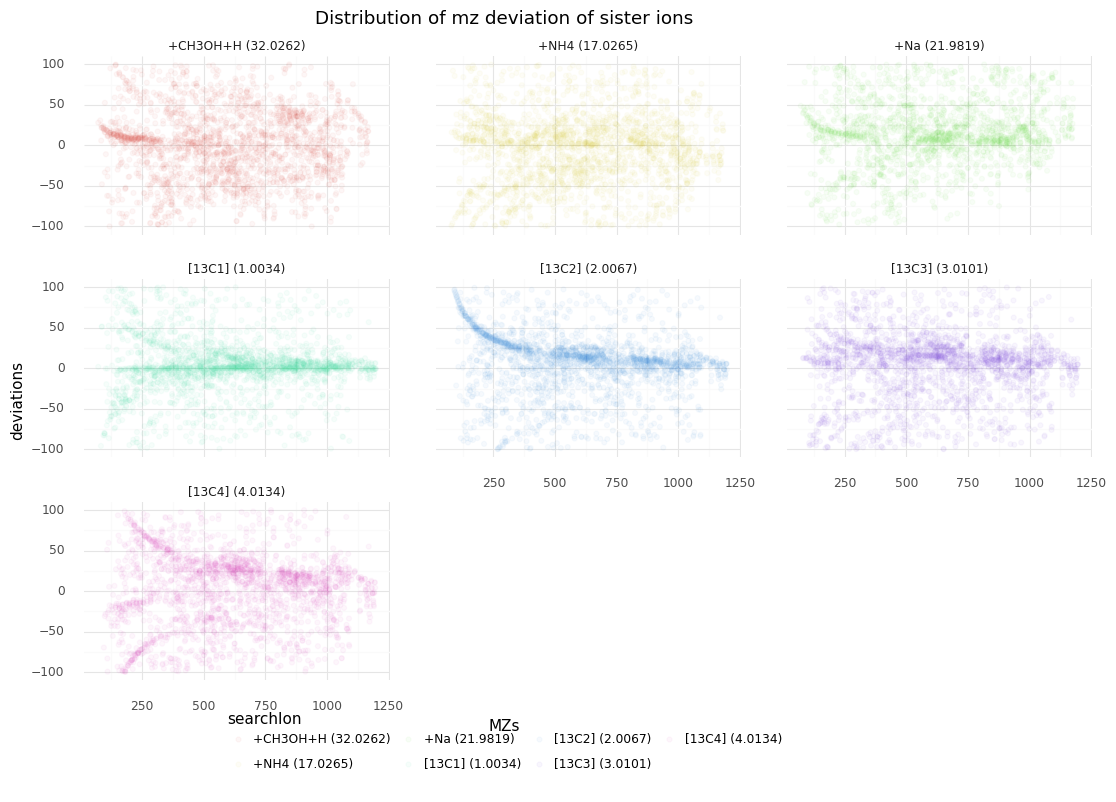

c:\Users\christoph\miniconda3\envs\ms\lib\site-packages\plotnine\layer.py:411: PlotnineWarning: geom_point : Removed 23 rows containing missing values.


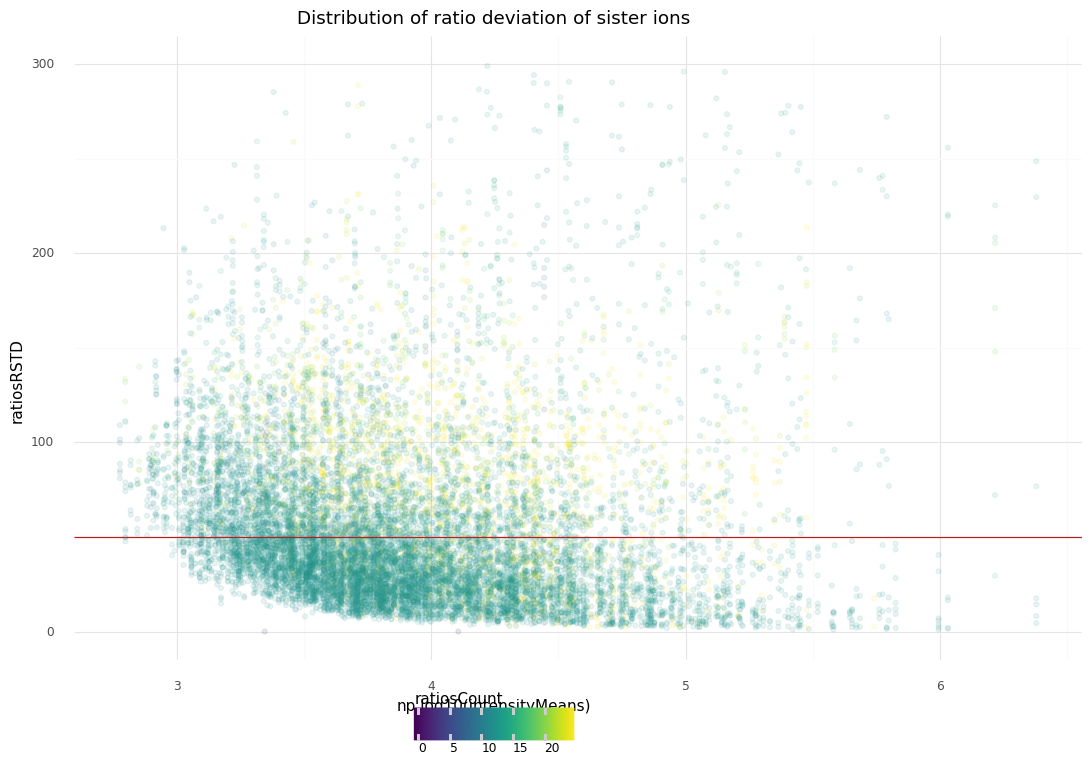

INFO:root:| intensityMeansCUT   |   ('ratiosRSTD', 'count') |   ('ratiosRSTD', 'mean') |   ('ratiosRSTD', 'std') |   ('ratiosRSTD', 'min') |   ('ratiosRSTD', '25%') |   ('ratiosRSTD', '50%') |   ('ratiosRSTD', '75%') |   ('ratiosRSTD', 'max') |
|:--------------------|--------------------------:|-------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|
| (2.772, 3.136]      |                       100 |                  80.1753 |                 30.188  |                28.4728  |                58.3905  |                76.0269  |                99.6314  |                184.789  |
| (3.136, 3.496]      |                       410 |                  67.5586 |                 40.1204 |                14.8295  |                38.8897  |                56.1494  |                85.884   |                285.255  |
| (3.496, 3.857]      |                       646 

INFO:root:There are 2642 features and 24 samples in the data matrix
INFO:root:The groups are Airblank, Inj2ul, Inj10ul


In [6]:
if os.path.exists(temp_file) and os.path.isfile(temp_file):
    dartMSAssay = ms.dartms.DartMSAssay.read_from_dill_file(temp_file)

if dartMSAssay.dat is None:
    logging.info("Generating matrix")
    dartMSAssay.build_data_matrix(on="originalData", originalData_mz_deviation_multiplier_PPM=30, aggregation_fun="average")
    annotations = dartMSAssay.annotate_features(useGroups=["Airblank", "Inj2ul", "Inj10ul"], plot=True)

    dartMSAssay.save_self_to_dill_file(temp_file)

logging.info("There are %d features and %d samples in the data matrix" % (dartMSAssay.dat.shape[1], dartMSAssay.dat.shape[0]))
logging.info("The groups are %s" % (", ".join(natsort.natsorted(list(set(dartMSAssay.groups))))))


## Batch intensity shift correction

To account for batch effects, repetitively injected QC samples can be used. This correction is done by deriving a single correction factor from all features detected in a single batch relative to all batches. Then, all features are corrected by this factor separately in each batch. 

In [7]:
if False:
    dartMSAssay.batch_correction(by_group="Inj2ul", plot=True)


## Blank subtraction

Background and noise features are removed in the next code chunk. Here it is tested which features show higher abundances in the experimental groups than in different background groups. Then only features that are significantly more abundant will be used further, while others are filtered. The results of this background subtraction are illustrated as volcano plots to allow for fine-tuning of the parameters.  

INFO:root:Remove features that are likely only the background
D:\Projects/DARTMS/tidyms/src\tidyms\dartms.py:2093: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
c:\Users\christoph\miniconda3\envs\ms\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: divide by zero encountered in divide
c:\Users\christoph\miniconda3\envs\ms\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: invalid value encountered in double_scalars
c:\Users\christoph\miniconda3\envs\ms\lib\site-packages\plotnine\layer.py:411: PlotnineWarning: geom_point : Removed 1715 rows containing missing values.


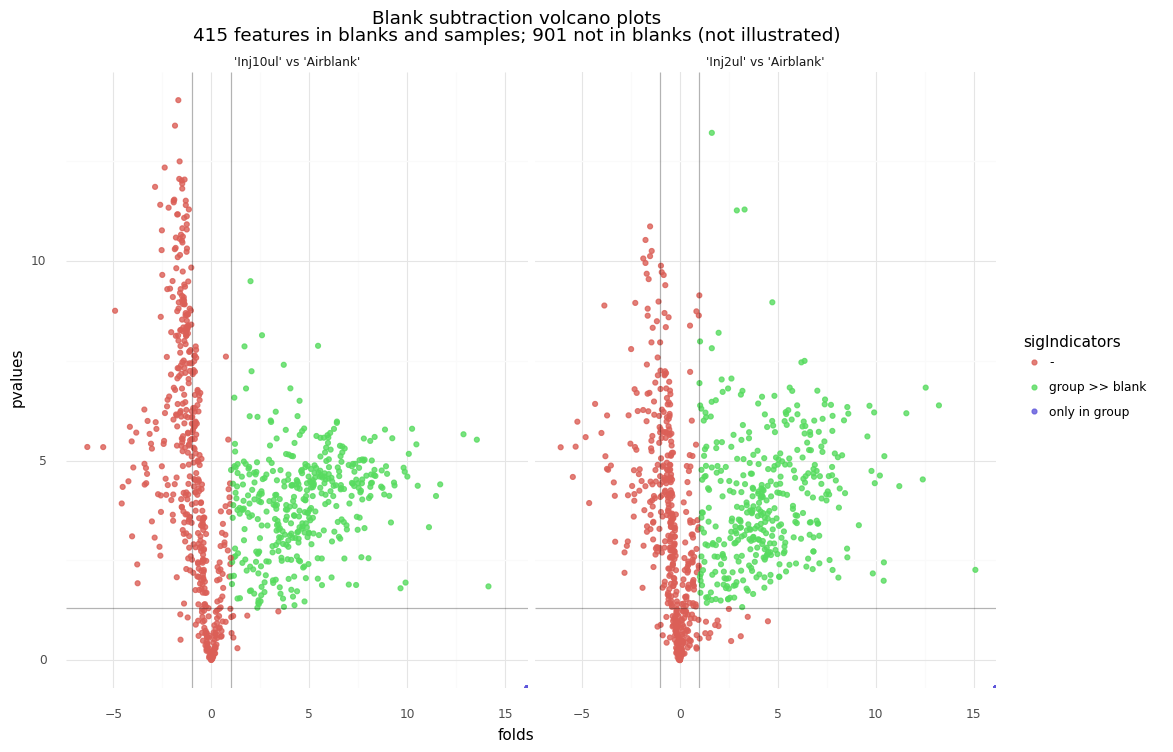

INFO:root:    .. 899 features not found in any of the blank samples, but at least in 2 samples of 2 groups and thus these features will be used
INFO:root:    .. 2 features not found in any of the blank samples, but at least in 2 samples of 1 groups and thus these features will be used
INFO:root:    .. 1326 features found in None of the blank comparisons with higher abundances in the samples. These features will be removed
INFO:root:    .. 38 features found in 1 of the blank comparisons with higher abundances in the samples and in at least 2 samples. These features will be used
INFO:root:    .. 377 features found in 2 of the blank comparisons with higher abundances in the samples and in at least 2 samples. These features will be used
INFO:root: Significance criteria are pval <= pvalueCutoff (0.050) and fold >= foldCutoff (2.0) and detected in at least 2 samples of a non-Blank group
INFO:root:    .. 1316 features remain in the dataset


exporting featureML: 100%|██████████| 1316/1316 [00:00<00:00, 6425.44it/s]


In [8]:
logging.info("Remove features that are likely only the background")
oFeatures = dartMSAssay.dat.shape[1]
dartMSAssay.blank_subtraction("Airblank", ["Inj2ul", "Inj10ul"], foldCutoff=2, plot=True)
dartMSAssay.write_bracketing_results_to_featureML(
    featureMLlocation="./bracketedResults_afterBlankSubtraction.featureML", featureMLStartRT=0, featureMLEndRT=1400
)


## High quality features

The blank subtraction removed many feature that are likely contaminants or other unspecific signals. The remaining features should represent true compounds found in the experimental conditions. 

To further filter the dataset for high-quality features, different filters can be applied. Only features fullfilling all filters will be used further.  

In [9]:
## Restrict features to high-quality ones

## Restrict to n most abundant features
# dartMSAssay.restrict_to_high_quality_features__most_n_abundant(
#    n_features = 500
# )

## Restrict to feautres found in at least x% of the replicates
dartMSAssay.restrict_to_high_quality_features__found_in_replicates(
    test_groups=["Inj2ul", "Inj10ul"], minimum_ratio_found=0.75, found_in_type="anyGroup"
)

## Minimum intensity filter
dartMSAssay.restrict_to_high_quality_features__minimum_intensity_filter(test_groups=["Inj2ul", "Inj10ul"], minimum_intensity=1e4)

## Maximum RSD value
dartMSAssay.restrict_to_high_quality_features__low_RSD_in_groups(test_groups=["Inj2ul", "Inj10ul"], maximum_RSD=0.4)

## Write used features to a new featureML file
dartMSAssay.write_bracketing_results_to_featureML(
    featureMLlocation="./bracketedResults_selectionHighQualityFeatures.featureML", featureMLStartRT=0, featureMLEndRT=1400
)


INFO:root: Using only features that are present in more than 75.0% replicates of any group to test
INFO:root:    .. using 1316 features
INFO:root: Using only features that have a minimum intensity of 10000.0 in at least one test-group
INFO:root:    .. using 535 features
INFO:root: Using only features that have a maximum RSD of 0.4 in all test-group
INFO:root:    .. using 454 features
exporting featureML: 100%|██████████| 454/454 [00:00<00:00, 4684.94it/s]


The above quality check removed another set of features that are complicated to work with. 

## Statistics

TidyMS' DARTMS module implements a couple of basic statistical comparisons directly for the genreated dataset. Furthermore, the results can be exported to TSV files and R objects to further inspect the dataset and apply more advance statistical methods. 

### Diagnostic information and plots

In [10]:
dartMSAssay.print_results_overview()


There are 454 features (columns) and 24 samples (rows) in the dataset
   .. 371 (81.7%) features have at least one missing value (np.nan)
Detected   Airblank   Inj10ul    Inj2ul  
       0        264                      
       1                                 
       2         25                   1  
       3         14                      
       4         18                      
       5          8                   2  
       6          5       454       451  
       7          4                      
       8          8                      
       9          6                      
      10          6                      
      11         13                      
      12         83                      
   total        190       454       454  


D:\Projects/DARTMS/tidyms/src\tidyms\dartms.py:2617: RuntimeWarning: divide by zero encountered in log2
c:\Users\christoph\miniconda3\envs\ms\lib\site-packages\plotnine\facets\facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


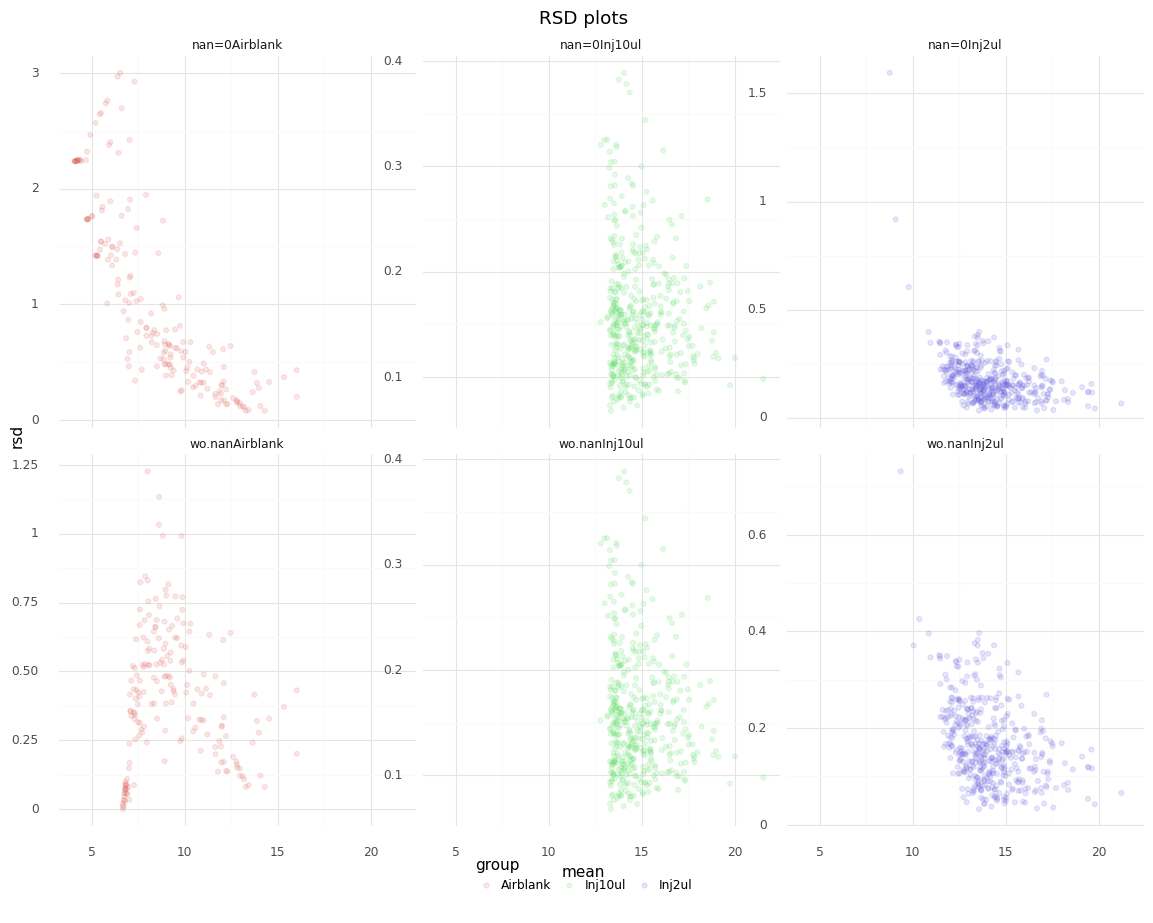


|                        |   count |     mean |       std |       min |      25% |      50% |      75% |      max |
|:-----------------------|--------:|---------:|----------:|----------:|---------:|---------:|---------:|---------:|
| ('Airblank', 'nan=0')  |     190 | 1.03555  | 0.778391  | 0.0809247 | 0.420309 | 0.736244 | 1.54281  | 3.00008  |
| ('Airblank', 'wo.nan') |     190 | 0.403271 | 0.243723  | 0         | 0.215306 | 0.411359 | 0.572957 | 1.22657  |
| ('Inj10ul', 'nan=0')   |     454 | 0.157964 | 0.0581199 | 0.0678045 | 0.114961 | 0.148138 | 0.185432 | 0.388762 |
| ('Inj10ul', 'wo.nan')  |     454 | 0.157964 | 0.0581199 | 0.0678045 | 0.114961 | 0.148138 | 0.185432 | 0.388762 |
| ('Inj2ul', 'nan=0')    |     454 | 0.170495 | 0.10999   | 0.0324417 | 0.109682 | 0.152834 | 0.215552 | 1.59491  |
| ('Inj2ul', 'wo.nan')   |     454 | 0.166996 | 0.0829842 | 0.0324417 | 0.109682 | 0.152834 | 0.215552 | 0.731227 |


In [11]:
p9.options.figure_size = (14, 10)  ## (20,12)
dartMSAssay.plot_RSDs_per_group(plotType="points")


### Univariate statistical analysis

100%|██████████| 454/454 [00:00<00:00, 927.39it/s]


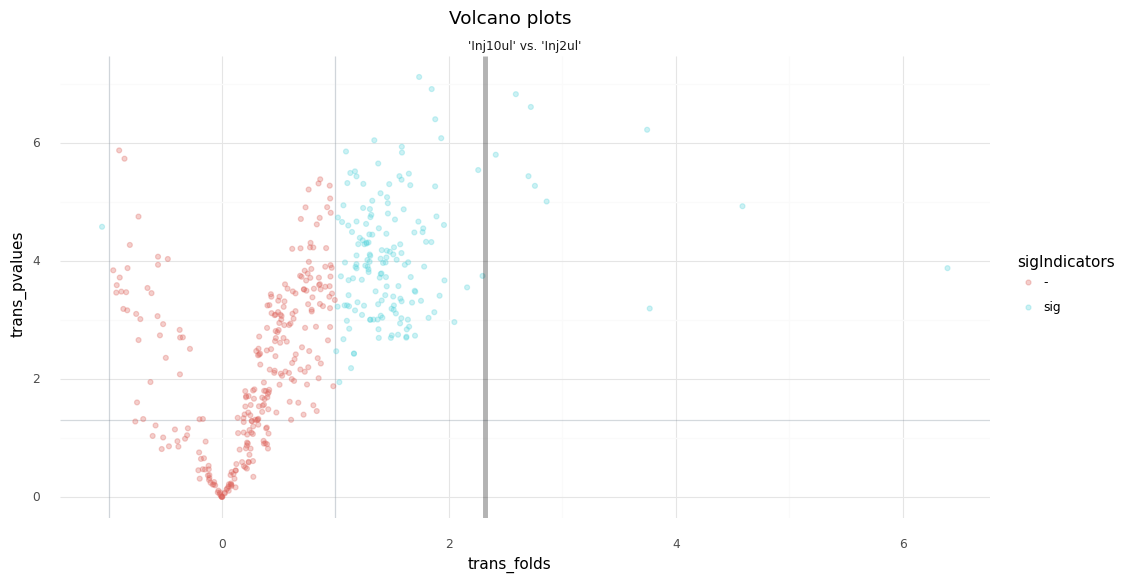

In [12]:
## Volcano plot

p9.options.figure_size = (12, 6)  ## (20,12)
import statsmodels.api as sm
from statsmodels.formula.api import ols

volcanoPlots = [["Inj10ul", "Inj2ul"]]  # , ["Inj2ul", "Airblank"], ["Inj10ul", "Airblank"]]

p, temp = dartMSAssay.calc_volcano_plots(volcanoPlots)
print(p + p9.geom_vline(xintercept=[np.log2(5)], alpha=0.3, colour="black", size=2) + p9.theme_minimal())


The volcano plot shows the comparison of the pre and post groups as well as with the QC samples.

Only few metabolites seem to be significantly different between the pre and post samples. However, a closer inspection of these using the boxplots shows, that in most cases the differences are not as large and consistend accross the samples as the volcano plot would suggest. Thus, it can be concluded, that there is no constituent difference between the pre and post samples. 

### Multivariate statistical analysis

#### PCA

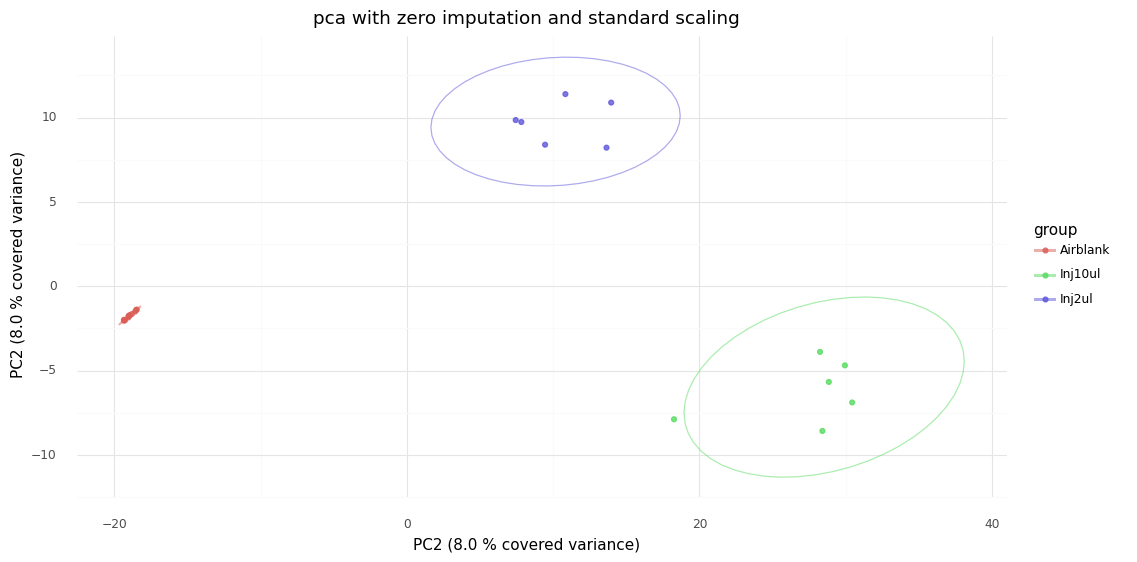

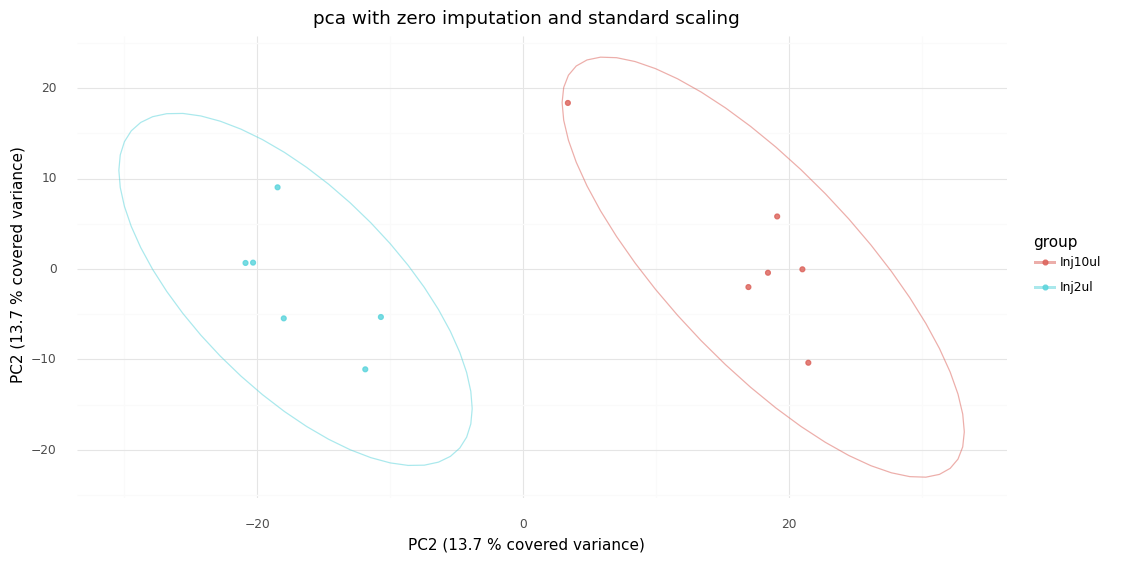

In [13]:
p, temp = dartMSAssay.calc_2D_Embedding(imputation="zero", scaling="standard", embedding="pca")
print(p + p9.theme_minimal())

p, temp = dartMSAssay.calc_2D_Embedding(imputation="zero", scaling="standard", embedding="pca", keep_groups=["Inj10ul", "Inj2ul"])
print(p + p9.theme_minimal())


#### LDA

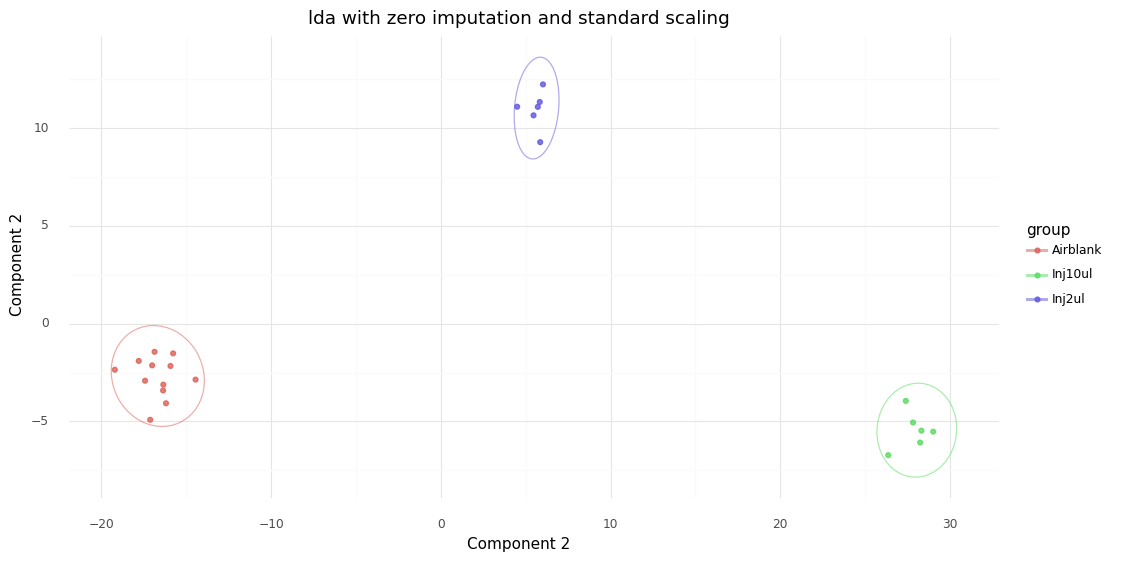

In [14]:
p, temp = dartMSAssay.calc_2D_Embedding(imputation="zero", scaling="standard", embedding="lda")
print(p + p9.theme_minimal())


#### UMAP

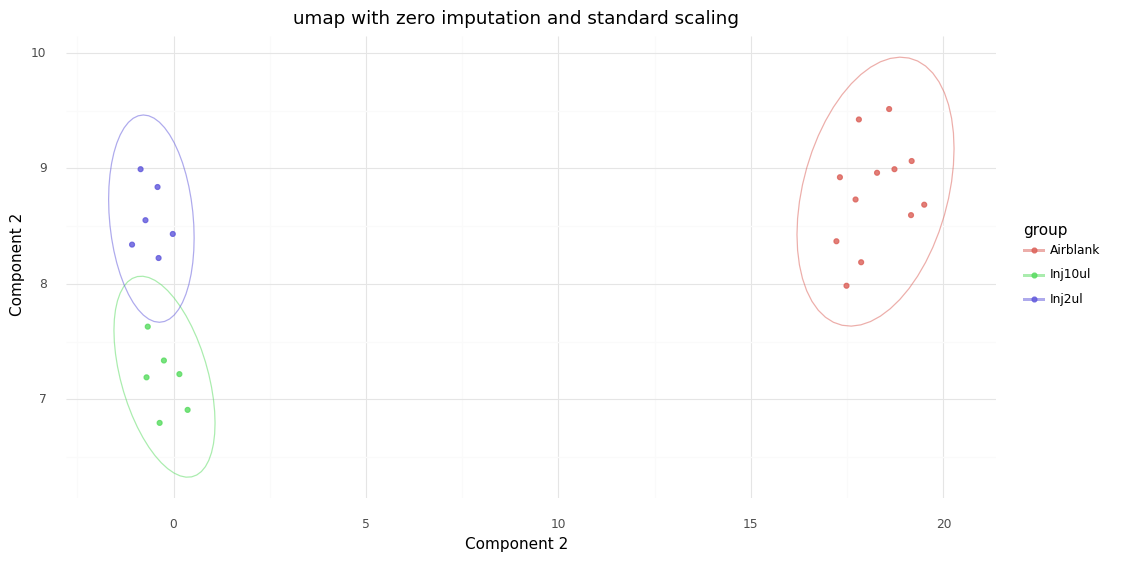

c:\Users\christoph\miniconda3\envs\ms\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1


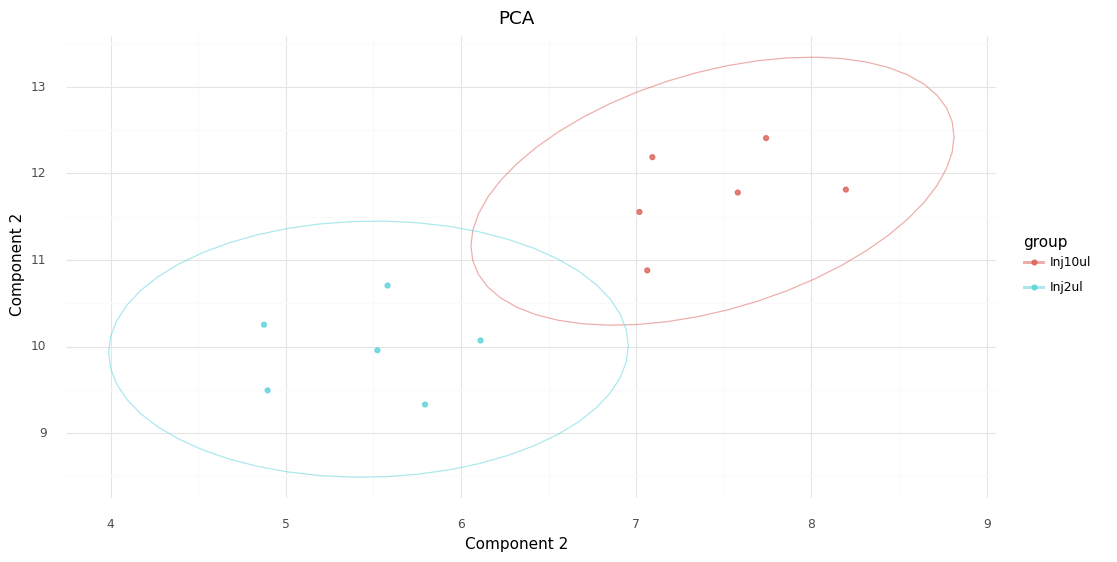

In [15]:
p, temp = dartMSAssay.calc_2D_Embedding(imputation="zero", scaling="standard", embedding="umap")
print(p + p9.theme_minimal())

p, temp = dartMSAssay.calc_2D_Embedding(imputation="zero", scaling="standard", embedding="umap", keep_groups=["Inj10ul", "Inj2ul"])
print(p + p9.theme_minimal() + p9.ggtitle("PCA"))


### Export of results 

In [16]:
## export for R
dartMSAssay.export_for_R("./exportedDataMatrix")

## generic use in Python
dat, features, featureAnnotations, samples, groups, batches = dartMSAssay.get_data_matrix_and_meta()


##
## Import data matrix
## 
## The following code imports the generated data matrix.
## Please note that when the file is moved or R is executed in a different
##      working directory, the path to the tsv file needs to be adapted accordingly
##
data = read.table('./exportedDataMatrix.tsv', header = TRUE, sep = '\t', stringsAsFactors = FALSE)
metaData = data[, 1:4]
data = data[,-(1:4)]
samples = c('VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING_rtShifted::Airblank_1)', 'VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING_rtShifted::Airblank_2)', 'VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING_rtShifted::Airblank_3)', 'VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING_rtShifted::Airblank_4)', 'VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING_rtShifted::Airblank_5)', 'VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING_rtShifted::Airblank_6)', 'VIRTUAL(20221222-HE-350V-400C-POS-MESH